In [74]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.losses import MeanSquaredError
from keras.optimizers import Adam, RMSprop

In [75]:
dataset = pd.read_csv('../dataset/dados_pregao_posi3.csv')
colunas = ['data_pregao', 'preco_ultimo_negocio']
data = dataset[colunas].copy()

data.loc[:, 'data_pregao'] = pd.to_datetime(data['data_pregao'])

data.set_index('data_pregao', inplace=True)

test_data = None
train_data = None
train_data_values = None
test_data_values = None

test_data = data.tail(30)
train_data = data.iloc[:-30]

train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values

data

,preco_ultimo_negocio
data_pregao,
2018-01-02,3.19
2018-01-03,3.25
2018-01-04,3.22
2018-01-05,3.36
2018-01-08,3.56
...,...
2024-10-01,5.82
2024-10-02,5.90
2024-10-03,5.80


30 DIAS

In [76]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [77]:
def objective(trial):
    units = trial.suggest_int('units', 32, 128)  
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units, activation='relu'))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=MeanSquaredError())

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    val_loss = model.evaluate(X_test, y_test, verbose=0)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print(f"Melhores Hiperparâmetros: {best_params}")

best_model = Sequential()
best_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(LSTM(best_params['units'], activation='relu'))
best_model.add(Dense(1))

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(optimizer=optimizer, loss=MeanSquaredError())

best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

predictions = best_model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

[I 2024-10-21 14:18:39,727] A new study created in memory with name: no-name-98fe5ed6-0153-434b-b549-dd0a3ac27e6e
[I 2024-10-21 14:20:34,385] Trial 0 finished with value: 0.08977670222520828 and parameters: {'units': 80, 'learning_rate': 6.703411448920675e-05, 'optimizer': 'adam'}. Best is trial 0 with value: 0.08977670222520828.
[I 2024-10-21 14:22:01,194] Trial 1 finished with value: 0.09301818907260895 and parameters: {'units': 63, 'learning_rate': 0.00062694085191936, 'optimizer': 'adam'}. Best is trial 0 with value: 0.08977670222520828.
[I 2024-10-21 14:23:40,443] Trial 2 finished with value: 0.08318386971950531 and parameters: {'units': 88, 'learning_rate': 0.004812801230632591, 'optimizer': 'adam'}. Best is trial 2 with value: 0.08318386971950531.
[I 2024-10-21 14:25:15,685] Trial 3 finished with value: 0.08380252122879028 and parameters: {'units': 80, 'learning_rate': 0.0003232892918042073, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.08318386971950531.
[I 2024-10-21 

Melhores Hiperparâmetros: {'units': 74, 'learning_rate': 0.00280632887146, 'optimizer': 'adam'}
Test Loss: 0.08177214860916138
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean Squared Error (MSE): 20.45511981208738
Root Mean Squared Error (RMSE): 4.522733665836115
Mean Absolute Percentage Error (MAPE): 75.90610189574207%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Mean Squared Error (MSE): 0.04483844777121128
Root Mean Squared Error (RMSE): 0.2117509097293593
Mean Absolute Percentage Error (MAPE): 2.4379557978505972%


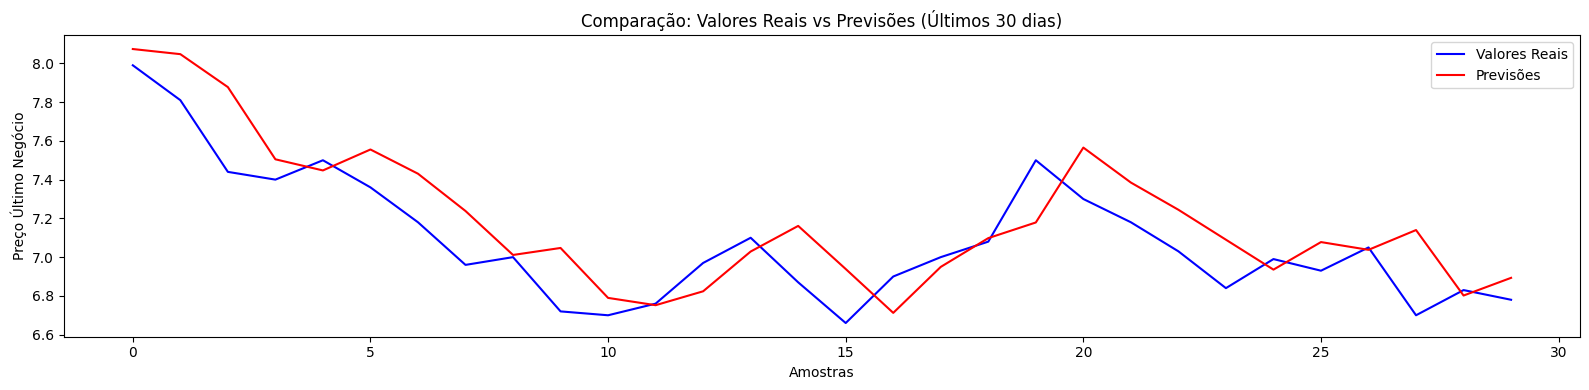

In [78]:
comparison_data = train_data.iloc[-60:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

predictions = best_model.predict(X_test_sequences)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 30 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

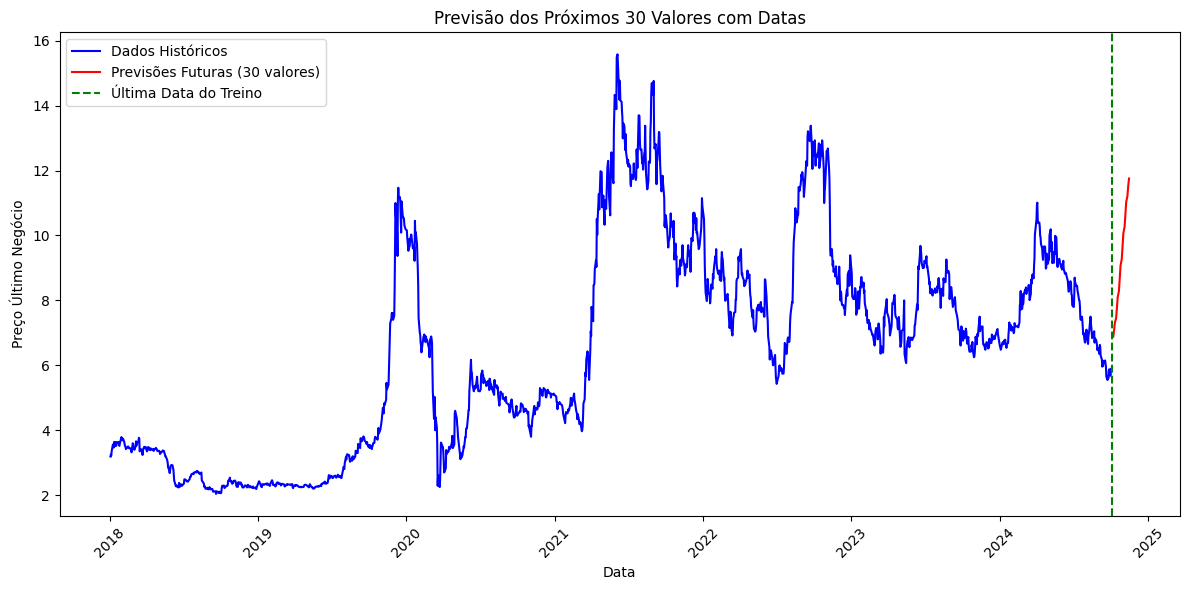

In [79]:
last_sequence = train_data_values[-sequence_length:]
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(30):
    next_prediction = best_model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

future_predictions = np.array(future_predictions).flatten()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (30 valores)', color='red')
plt.title('Previsão dos Próximos 30 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

60 DIAS

In [80]:
test_data = None
train_data = None
train_data_values = None
test_data_values = None

test_data = data.tail(60)
train_data = data.iloc[:-60]

train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values

In [81]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [82]:
def objective(trial):
    units = trial.suggest_int('units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units, activation='relu'))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=MeanSquaredError())

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    val_loss = model.evaluate(X_test, y_test, verbose=0)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Número de tentativas

best_params = study.best_params
print(f"Melhores Hiperparâmetros: {best_params}")

best_model = Sequential()
best_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(LSTM(best_params['units'], activation='relu'))
best_model.add(Dense(1))

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(optimizer=optimizer, loss=MeanSquaredError())

best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

predictions = best_model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

[I 2024-10-21 14:35:42,105] A new study created in memory with name: no-name-9758f1ba-97a2-43c4-807a-ba72d77cc239
[I 2024-10-21 14:38:01,823] Trial 0 finished with value: 0.08561784029006958 and parameters: {'units': 127, 'learning_rate': 0.0005608318477107008, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.08561784029006958.
[I 2024-10-21 14:39:37,619] Trial 1 finished with value: 0.1109849065542221 and parameters: {'units': 95, 'learning_rate': 0.0023718513536018374, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.08561784029006958.
[I 2024-10-21 14:41:04,914] Trial 2 finished with value: 0.12899354100227356 and parameters: {'units': 81, 'learning_rate': 0.005548708724868825, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.08561784029006958.
[I 2024-10-21 14:42:52,291] Trial 3 finished with value: 0.0846233144402504 and parameters: {'units': 89, 'learning_rate': 0.00011939909852149359, 'optimizer': 'adam'}. Best is trial 3 with value: 0.0846233144402504.
[I 2024

Melhores Hiperparâmetros: {'units': 82, 'learning_rate': 0.0015144364510944446, 'optimizer': 'adam'}
Test Loss: 0.10579604655504227
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Squared Error (MSE): 20.79463734740655
Root Mean Squared Error (RMSE): 4.560113742814597
Mean Absolute Percentage Error (MAPE): 77.38689557641304%


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean Squared Error (MSE): 0.10263608922776021
Root Mean Squared Error (RMSE): 0.3203686770390642
Mean Absolute Percentage Error (MAPE): 3.040483323355392%


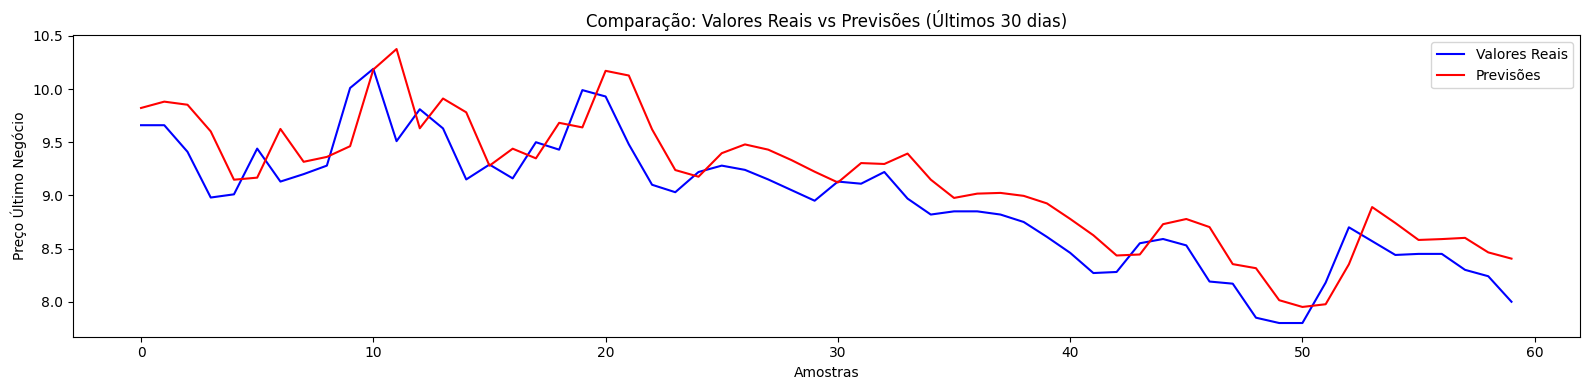

In [83]:
comparison_data = train_data.iloc[-90:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

predictions = best_model.predict(X_test_sequences)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 30 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

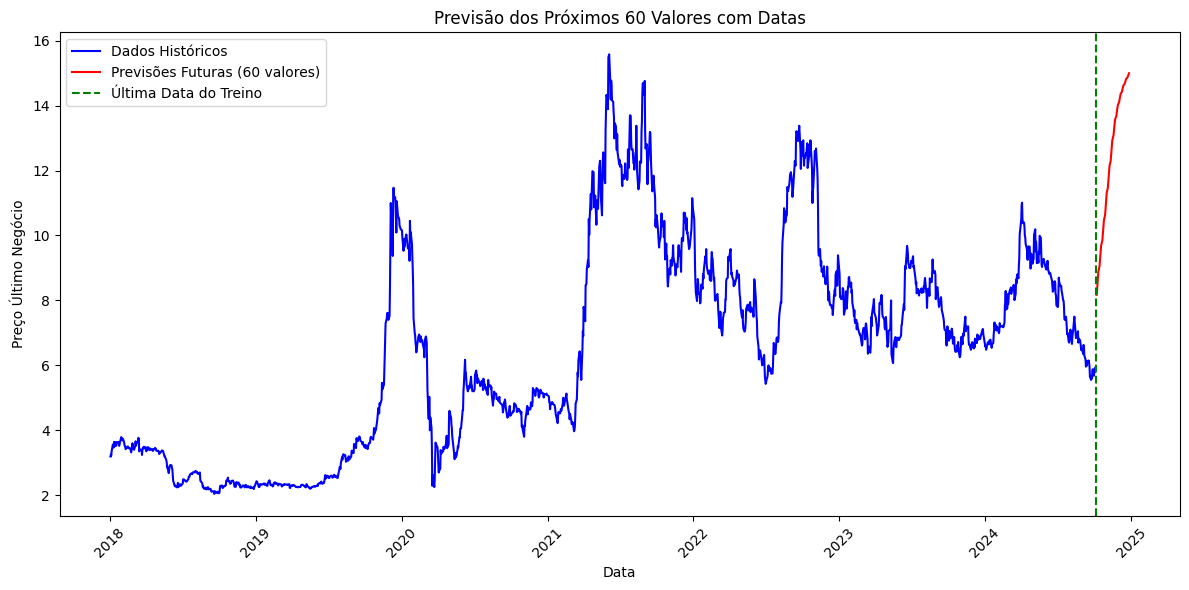

In [84]:
last_sequence = train_data_values[-sequence_length:]
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(60):
    next_prediction = best_model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

future_predictions = np.array(future_predictions).flatten()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='B')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (60 valores)', color='red')
plt.title('Previsão dos Próximos 60 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

90 DIAS

In [85]:
test_data = None
train_data = None
train_data_values = None
test_data_values = None

test_data = data.tail(90)
train_data = data.iloc[:-90]

train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values

In [86]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  

In [87]:
def objective(trial):
    units = trial.suggest_int('units', 32, 128) 
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units, activation='relu'))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=MeanSquaredError())

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    val_loss = model.evaluate(X_test, y_test, verbose=0)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) 

best_params = study.best_params
print(f"Melhores Hiperparâmetros: {best_params}")

best_model = Sequential()
best_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(LSTM(best_params['units'], activation='relu'))
best_model.add(Dense(1))

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(optimizer=optimizer, loss=MeanSquaredError())

best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

predictions = best_model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

[I 2024-10-21 14:54:07,991] A new study created in memory with name: no-name-afb5f30a-2be1-4f8d-a3bc-844b9c148bd3
[I 2024-10-21 14:55:43,323] Trial 0 finished with value: 0.127343088388443 and parameters: {'units': 75, 'learning_rate': 0.009252669185037178, 'optimizer': 'adam'}. Best is trial 0 with value: 0.127343088388443.
[I 2024-10-21 14:57:08,439] Trial 1 finished with value: 0.08416154235601425 and parameters: {'units': 74, 'learning_rate': 0.0020392119335670856, 'optimizer': 'adam'}. Best is trial 1 with value: 0.08416154235601425.
[I 2024-10-21 14:59:49,964] Trial 2 finished with value: 0.12729975581169128 and parameters: {'units': 120, 'learning_rate': 0.0009066753475080085, 'optimizer': 'adam'}. Best is trial 1 with value: 0.08416154235601425.
[I 2024-10-21 15:01:25,842] Trial 3 finished with value: 0.09832051396369934 and parameters: {'units': 77, 'learning_rate': 8.846526477934239e-05, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.08416154235601425.
[I 2024-10-21 1

Melhores Hiperparâmetros: {'units': 125, 'learning_rate': 0.0016999031148436643, 'optimizer': 'rmsprop'}
Test Loss: 0.09469126909971237
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Mean Squared Error (MSE): 21.154235096630455
Root Mean Squared Error (RMSE): 4.599373337383089
Mean Absolute Percentage Error (MAPE): 77.74217884322164%


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean Squared Error (MSE): 0.09110497518334398
Root Mean Squared Error (RMSE): 0.30183600710210834
Mean Absolute Percentage Error (MAPE): 2.715038869880466%


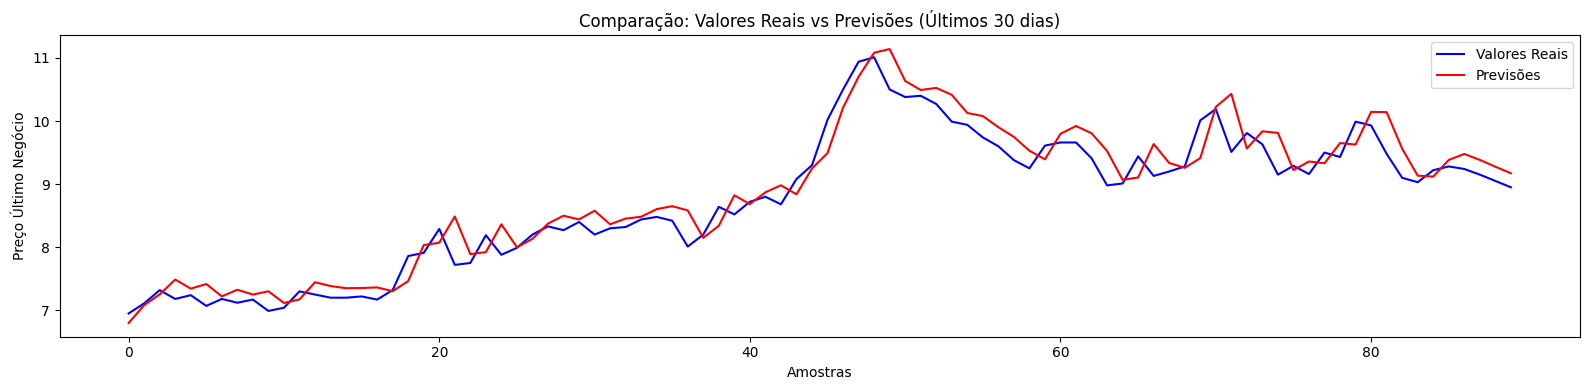

In [88]:
comparison_data = train_data.iloc[-120:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

predictions = best_model.predict(X_test_sequences)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 30 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

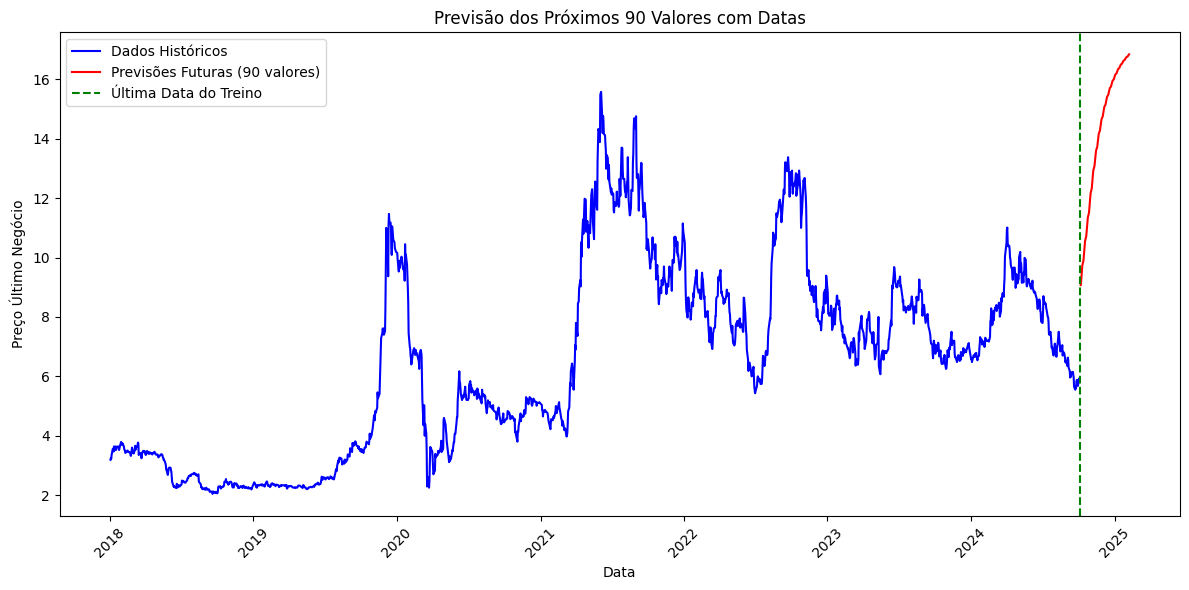

In [89]:
last_sequence = train_data_values[-sequence_length:]
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(90):
    next_prediction = best_model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

future_predictions = np.array(future_predictions).flatten()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='B')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (90 valores)', color='red')
plt.title('Previsão dos Próximos 90 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()